In [138]:
""" Calculate the rate at which streamflow carries away cations from 
Hubbard Brook watershed 1 """
import xarray as xr
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [139]:
data = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.156.8/W1Long_StrmChem_HB1991-2020.csv",
                   index_col = [0, 2], parse_dates=True)
data = data[['pH','Ca2', 'Mg2', 'Na', 'K', 'Alt']].sort_index() # 'Elevation',
data[data < -800] = np.nan

# some sites have measurements at two elevations, average them
duplicate_sites = data.index[data.index.to_frame().reset_index(drop = True).duplicated()]

temp = data.loc[duplicate_sites, :]
temp = temp.groupby(temp.index).mean()
temp.index = pd.MultiIndex.from_tuples(temp.index, names = ['Site', 'Date'])
data.loc[temp.index, :] = temp

data = data.drop_duplicates()

# average over all the sites in a watershed
data = data.groupby(data.index.get_level_values(0)).mean()

# limit to pre-application
data = data.loc[data.index.get_level_values(0) < pd.Timestamp('1999-10-19'), :]

C:\Users\ywo\AppData\Local\Temp\ipykernel_27408\585413903.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.156.8/W1Long_StrmChem_HB1991-2020.csv",


<Axes: xlabel='Date'>

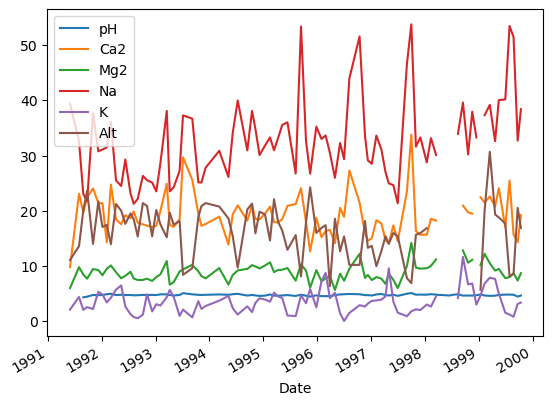

In [140]:
data.plot()

In [141]:
data.mean()

pH      4.741187
Ca2    19.091124
Mg2     8.838547
Na     32.559828
K       3.598750
Alt    16.287187
dtype: float64

## convert the cation flux from umol/L to g m-3 s-1 using streamflow

Text(0, 0.5, 'mm/day')

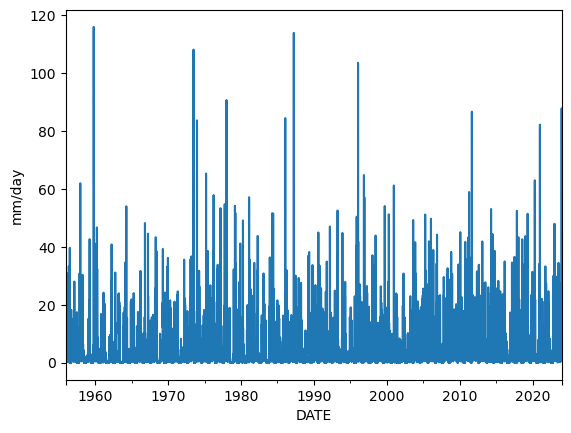

In [142]:
streamflow = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.2.14/HBEF_DailyStreamflow_1956-2023.csv", index_col = 0, parse_dates = True)
streamflow = streamflow.loc[streamflow['WS'] == 1, 'Streamflow']
streamflow.plot()
plt.ylabel('mm/day')

In [145]:
# Streamflow rate in mm/day = 10-3 m3/day / Area of watershed (m2)
# Concentration umol/L = 1e-3 mol/m3
# 
# Therefore, total transported amount is: 
# 
# (Concentration /1000) mol/m3 * (Streamflow rate / 1000) m3/day / Area of watershed (m2)
#    = Concentration * Streamflow rate / 1e6 mol / day / m2
#
# and convert this further to mol/m2/second and multiply by cation molar mass
cation_mass = {'Ca2': 40.078, 'Mg2': 24.305, 'Na': 22.99, 'K': 39.0983, 'Alt': 26.98}

cations = data.drop('pH', axis = 1)
export_rates = pd.DataFrame(np.nan, index = cations.index, columns = cations.columns)
for col in cations.columns:
    export_rates.loc[:, col] = (streamflow.loc[cations.index] * cations[col]) / 1e6 / 86400

Text(0, 0.5, 'g/m2/s')

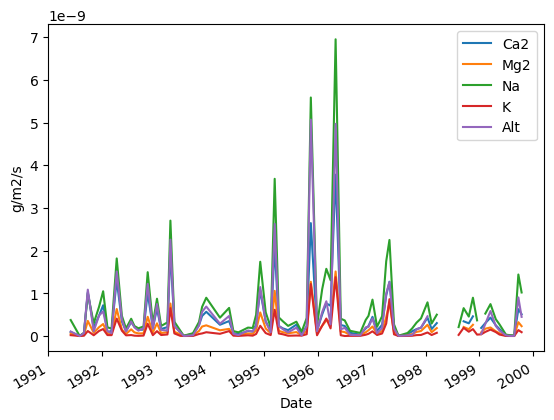

In [147]:
export_rates.plot()
plt.ylabel('g/m2/s')

In [148]:
export_rates.mean()

Ca2    4.116595e-10
Mg2    1.921649e-10
Na     6.981545e-10
K      1.169056e-10
Alt    4.701224e-10
dtype: float64